# CS156 - Pipeline - First Draft

## Which Video Will I Like?

### Problem Definition

The objective of this project is to predict whether I will "like" a YouTube video based solely on its metadata before watching it. Although Youtube has its own recommendation algorithm that recommends me vidoes, I felt that I don't always enjoy the videos recommended by Youtube. I have a high criteria for liking a video; I only press the "like" ("thumbs up") button when I really like the video or want to watch the video again. But what exactly is the criteria? By analyzing patterns in the metadata of videos I have previously liked versus those I have watched but not liked, we aim to build a machine learning model that can forecast my likelihood of liking new videos.


#### Objectives

- **Data Acquisition**: Collect metadata from a balanced dataset of liked and unliked videos.
- **Feature Extraction**: Identify and extract relevant metadata features that may influence liking behavior.
- **Model Development**: Train machine learning models to predict the likelihood of liking a video.
- **Evaluation**: Assess model performance using appropriate metrics.
- **Analysis**: Interpret the results to understand key factors influencing the predictions.

### Data Collection

To build a robust predictive model, we will collect data from two categories:

1. **Liked Videos (Positive Class)**:
   - **Source**: Videos on which I have pressed the "like" button.
   - **Quantity**: 200 videos.
   - **Method**: Use the YouTube Data API to retrieve metadata of liked videos.

2. **Unliked Videos (Negative Class)**:
   - **Source**: Videos I have watched but did not press the "like" button.
   - **Quantity**: Randomly select 200 videos from a pool of 1,000 recently watched unliked videos.
   - **Method**:
     - Extract watch history from `watch-history.html` obtained via Google Takeout.
     - Filter out videos that have been liked.
     - Randomly select 200 unliked videos to match the number of liked videos.

### Feature Extraction

Relevant metadata features to be extracted include:

- **Video Attributes**:
  - Title
  - Description
  - Tags
  - Category ID
  - Duration
  - Default Audio Language
  - Topic Categories

- **Engagement Metrics**:
  - View Count
  - Like Count
  - Comment Count

- **Content Details**:
  - Published Date and Time
  - Content Rating
  - Definition (HD or SD)

### Data Preprocessing

To prepare the data for modeling, the following preprocessing steps will be applied:

- **Data Cleaning**:
  - Handle missing or null values.
  - Remove duplicates.

- **Feature Engineering**:
  - Convert duration to total seconds.
  - Extract textual features from title and description (e.g., word counts, sentiment scores).
  - Categorize view counts, like counts, and comment counts into bins.

- **Encoding Categorical Variables**:
  - Use one-hot encoding for categorical features like category ID and language.
  - Encode textual features using techniques like TF-IDF vectors for titles and descriptions.

- **Normalization and Scaling**:
  - Scale numerical features to ensure uniformity.

### Modeling

Multiple machine learning algorithms will be explored to find the best predictive model:

- **Baseline Models**:
  - Logistic Regression
  - Decision Trees

- **Advanced Models**:
  - Random Forests
  - Gradient Boosting Machines (e.g., XGBoost, LightGBM)
  - Support Vector Machines
  - Neural Networks (for more complex patterns)

### Evaluation

Models will be evaluated using cross-validation and the following performance metrics:

- **Accuracy**: Overall correctness of the model.
- **Precision**: Correctly predicted likes out of all predicted likes.
- **Recall**: Correctly predicted likes out of all actual likes.
- **F1-Score**: Harmonic mean of precision and recall.
- **Confusion Matrix**: To visualize true vs. predicted classifications.
- **ROC Curve and AUC Score**: To evaluate the model's ability to discriminate between classes.

### Expected Challenges

- **Imbalanced Data**: Ensuring the dataset remains balanced to prevent bias.
- **Feature Selection**: Identifying which metadata features are most predictive.
- **Overfitting**: Avoiding models that perform well on training data but poorly on unseen data.
- **Data Privacy**: Handling personal data securely and ethically.

### Results Interpretation

After training and evaluating the models, we will:

- **Identify Key Predictors**: Determine which features most influence the likelihood of liking a video.
- **Model Comparison**: Compare the performance of different algorithms to select the best model.
- **Practical Implications**: Discuss how the model could be used in real-world scenarios, such as enhancing YouTube's recommendation system.

### Conclusion

This project aims to create a personalized predictive model for liking YouTube videos based on metadata. Successful completion could lead to improved content recommendations and a deeper understanding of personal viewing habits.

### Future Work

- **Expand Feature Set**: Incorporate additional metadata or user interaction features.
- **Time-Series Analysis**: Analyze how preferences change over time.
- **Apply to Other Users**: Test the model's applicability to predict likes for other users.



### Section 2: Converting data into Python dataframe

In [61]:
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

# Set up OAuth 2.0 authentication flow
scopes = ["https://www.googleapis.com/auth/youtube.force-ssl"]
client_secrets_file = "../../../Desktop/client_secret.json"

# Create an OAuth flow and get credentials using the local server method
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
    client_secrets_file, scopes)

# Use run_local_server() to initiate the OAuth flow
flow.redirect_uri = 'http://localhost:5001/oauth2callback'
credentials = flow.run_local_server(port=5001)

# Create a YouTube client
youtube = googleapiclient.discovery.build("youtube", "v3", credentials=credentials)


# Request liked videos
request = youtube.videos().list(
    part="snippet,contentDetails",
    myRating="like"
)
response = request.execute()

# # Process and print video details
# for item in response.get("items", []):
#     title = item["snippet"]["title"]
#     video_id = item["id"]
#     print(f"Title: {title}, Video ID: {video_id}")


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=217986578119-0l6jjn9u267th7o7rh7bm2uqffaqqq96.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A5001%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=Q7LNOHuTQeyvvNaR5vfkRMeRBMH6VO&access_type=offline


In [100]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import random

In [101]:


def get_liked_videos(max_results=200):
    videos = []
    next_page_token = None

    while len(videos) < max_results:
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,topicDetails",
            myRating="like",
            maxResults=50,
            pageToken=next_page_token
        )

        response = request.execute()
        videos.extend(response.get("items", []))

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return videos[:max_results]

def get_random_videos_details(video_ids):
    videos = []
    for i in range(0, len(video_ids), 50):
        try:
            request = youtube.videos().list(
                part="snippet,contentDetails,statistics,topicDetails",
                id=','.join(video_ids[i:i+50])
            )
            response = request.execute()
            videos.extend(response.get("items", []))
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
    return videos

def get_recently_watched_videos_from_html(file_path, max_results=1000):
    # Read the HTML file
    with open(file_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f, 'lxml')

    # Find all watch history entries
    entries = soup.find_all('div', class_='mdl-grid')

    video_ids = []
    for entry in entries:
        # Find the anchor tag with the video URL
        a_tag = entry.find('a')
        if a_tag and 'youtube.com/watch' in a_tag.get('href', ''):
            url = a_tag['href']
            # Extract the video ID using regex
            match = re.search(r'v=([^&]+)', url)
            if match:
                video_id = match.group(1)
                video_ids.append(video_id)
                if len(video_ids) >= max_results:
                    break

    # Remove duplicates while preserving order
    video_ids = list(dict.fromkeys(video_ids))

    return video_ids

def create_dataframe(video_items, category):
    data = []
    for item in video_items:
        snippet = item.get("snippet", {})
        content_details = item.get("contentDetails", {})
        statistics = item.get("statistics", {})
        topic_details = item.get("topicDetails", {})

        video_info = {
            "like": category,
            "title": snippet.get("title", "N/A"),
            "description": snippet.get("description", "N/A"),
            "tags": snippet.get("tags", "N/A"),
            "category_id": snippet.get("categoryId", "N/A"),
            "duration": content_details.get("duration", "N/A"),
            "view_count": int(statistics.get("viewCount", 0)),
            "like_count": int(statistics.get("likeCount", 0)),
            "comment_count": int(statistics.get("commentCount", 0)),
            "topic_categories": topic_details.get("topicCategories", "N/A"),
            "language": snippet.get("defaultAudioLanguage", snippet.get("defaultLanguage", "N/A"))
        }
        data.append(video_info)
    return pd.DataFrame(data)

# Provide the path to your watch-history.html file
file_path = '/Users/hcoh/Downloads/Takeout 3/YouTube and YouTube Music/history/watch-history.html'

# Get 200 liked videos
liked_videos = get_liked_videos(max_results=200)

# Extract liked video IDs
liked_video_ids = [item['id'] for item in liked_videos]

# Get 1000 recently watched video IDs
recently_watched_video_ids = get_recently_watched_videos_from_html(file_path, max_results=1000)

# Filter out liked videos
unliked_video_ids = [vid for vid in recently_watched_video_ids if vid not in liked_video_ids]
unliked_sample_ids = random.sample(unliked_video_ids, 200)

# Fetch details of the unliked sampled videos
unliked_videos = get_random_videos_details(unliked_sample_ids)

# Create DataFrames for liked and unliked videos
liked_videos_df = create_dataframe(liked_videos, 1)
unliked_videos_df = create_dataframe(unliked_videos, 0)

# Combine both DataFrames
combined_df = pd.concat([liked_videos_df, unliked_videos_df], ignore_index=True)

# Save DataFrame to CSV
combined_df.to_csv("combined_videos.csv", index=False)


In [102]:
combined_df

,like,title,description,tags,category_id,duration,view_count,like_count,comment_count,topic_categories,language
0,1,"개발자 취업, 100% 성공하는 포트폴리오 작성법",#개발자취업 #코딩공부 #개발자면접 #개발자포트폴리오 #개발자공부 #개발자이력서\n...,"[#개발자취엽, #개발자취없, #개발자치업, #개발자치엽, #개발자취엡, #코딩궁부...",26,PT14M11S,244,20,7,[https://en.wikipedia.org/wiki/Knowledge],ko
1,1,What Is Dynamic Programming and How To Use It,**Dynamic Programming Tutorial**\nThis is a qu...,"[dynamic programming tutorial, dynamic program...",27,PT14M28S,1606583,41530,1619,[https://en.wikipedia.org/wiki/Knowledge],en
2,1,만능 반찬 소고기소보루 레시피 🐮,,N/A,22,PT28S,59191,992,15,[https://en.wikipedia.org/wiki/Food],N/A
3,1,이무진 신곡 스포 멜로디만 보고 코드 맞추기,#이무진 #청춘만화 #라디오스타 #노래 #음악 #피아노 #기타 \n#Sofa4844...,"[Sofa4844, Shorts, 음악, 노래, 피아노, 이무진, 신호등, 청춘만화...",10,PT29S,1592422,29253,1276,"[https://en.wikipedia.org/wiki/Music, https://...",ko
4,1,"유명 컨퍼런스 모델로 트레이딩 하기 (PatchTST, ICLR 2023)",blog : https://jetechnology.tistory.com/64,"[AI, 트레이딩, 투자, 주식, 암호화폐, 코인]",28,PT7M19S,531,26,3,[https://en.wikipedia.org/wiki/Knowledge],N/A
...,...,...,...,...,...,...,...,...,...,...,...
395,0,도박의 위험성 (성인용 동숲),#혜안 #shorts,[혜안],20,PT46S,7351156,168550,323,"[https://en.wikipedia.org/wiki/Casual_game, ht...",N/A
396,0,a little secret for binary tree questions 🤫,🚀 https://neetcode.io/ - Get lifetime access t...,N/A,27,PT1M,58201,4412,48,"[https://en.wikipedia.org/wiki/Knowledge, http...",en
397,0,고물가 시대에 한 달 식비 20만원으로 배 터지게 먹는 방법,시청해 주셔서 감사합니다. 행복한 하루 되세요.\n이 포스팅은 쿠팡 파트너스 활동의...,N/A,24,PT5M54S,199835,5680,441,"[https://en.wikipedia.org/wiki/Food, https://e...",ko
398,0,#кролики_содержание #кролики #@masha.marachkov...,,N/A,22,PT15S,587,14,0,[https://en.wikipedia.org/wiki/Pet],N/A


In [103]:
import pandas as pd
import re

# Load the data
df = combined_df

# Convert ISO 8601 duration format to seconds
def iso_duration_to_seconds(duration):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', duration)
    if not match:
        return 0
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    seconds = int(match.group(3)) if match.group(3) else 0
    return hours * 3600 + minutes * 60 + seconds

df['duration_seconds'] = df['duration'].apply(iso_duration_to_seconds)

# Create a new variable 'like_ratio' which is like_count / view_count
df['like_ratio'] = df['like_count'] / df['view_count']
df['like_ratio'] = df['like_ratio'].fillna(0)  # Replace NaNs with 0

# Extract the last word from each URL in the 'topic_categories' list
def extract_last_words(topic_list):
    if isinstance(topic_list, list):
        last_words = []
        for url in topic_list:
            # Extract the last word from the URL
            match = re.search(r'/([^/]+)$', url)
            if match:
                last_words.append(match.group(1))
        return ' '.join(last_words)
    return ''

# If 'topic_categories' is read as a string, convert it to a list before applying the function
df['topic_categories'] = df['topic_categories'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['topic_categories_extracted'] = df['topic_categories'].apply(extract_last_words)

# Display the modified DataFrame
df


,like,title,description,tags,category_id,duration,view_count,like_count,comment_count,topic_categories,language,duration_seconds,like_ratio,topic_categories_extracted
0,1,"개발자 취업, 100% 성공하는 포트폴리오 작성법",#개발자취업 #코딩공부 #개발자면접 #개발자포트폴리오 #개발자공부 #개발자이력서\n...,"[#개발자취엽, #개발자취없, #개발자치업, #개발자치엽, #개발자취엡, #코딩궁부...",26,PT14M11S,244,20,7,[https://en.wikipedia.org/wiki/Knowledge],ko,851,0.081967,Knowledge
1,1,What Is Dynamic Programming and How To Use It,**Dynamic Programming Tutorial**\nThis is a qu...,"[dynamic programming tutorial, dynamic program...",27,PT14M28S,1606583,41530,1619,[https://en.wikipedia.org/wiki/Knowledge],en,868,0.025850,Knowledge
2,1,만능 반찬 소고기소보루 레시피 🐮,,N/A,22,PT28S,59191,992,15,[https://en.wikipedia.org/wiki/Food],N/A,28,0.016759,Food
3,1,이무진 신곡 스포 멜로디만 보고 코드 맞추기,#이무진 #청춘만화 #라디오스타 #노래 #음악 #피아노 #기타 \n#Sofa4844...,"[Sofa4844, Shorts, 음악, 노래, 피아노, 이무진, 신호등, 청춘만화...",10,PT29S,1592422,29253,1276,"[https://en.wikipedia.org/wiki/Music, https://...",ko,29,0.018370,Music Music_of_Asia Pop_music
4,1,"유명 컨퍼런스 모델로 트레이딩 하기 (PatchTST, ICLR 2023)",blog : https://jetechnology.tistory.com/64,"[AI, 트레이딩, 투자, 주식, 암호화폐, 코인]",28,PT7M19S,531,26,3,[https://en.wikipedia.org/wiki/Knowledge],N/A,439,0.048964,Knowledge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,도박의 위험성 (성인용 동숲),#혜안 #shorts,[혜안],20,PT46S,7351156,168550,323,"[https://en.wikipedia.org/wiki/Casual_game, ht...",N/A,46,0.022928,Casual_game Video_game_culture
396,0,a little secret for binary tree questions 🤫,🚀 https://neetcode.io/ - Get lifetime access t...,N/A,27,PT1M,58201,4412,48,"[https://en.wikipedia.org/wiki/Knowledge, http...",en,60,0.075806,Knowledge Technology
397,0,고물가 시대에 한 달 식비 20만원으로 배 터지게 먹는 방법,시청해 주셔서 감사합니다. 행복한 하루 되세요.\n이 포스팅은 쿠팡 파트너스 활동의...,N/A,24,PT5M54S,199835,5680,441,"[https://en.wikipedia.org/wiki/Food, https://e...",ko,354,0.028423,Food Lifestyle_(sociology)
398,0,#кролики_содержание #кролики #@masha.marachkov...,,N/A,22,PT15S,587,14,0,[https://en.wikipedia.org/wiki/Pet],N/A,15,0.023850,Pet



Dataset Summary:
             like    view_count    like_count  comment_count  \
count  400.000000  4.000000e+02  4.000000e+02     400.000000   
mean     0.500000  5.067598e+06  8.156637e+04     942.105000   
std      0.500626  1.501177e+07  3.180949e+05    2503.265578   
min      0.000000  1.400000e+01  0.000000e+00       0.000000   
25%      0.000000  8.502800e+04  1.665000e+03      42.000000   
50%      0.500000  5.016880e+05  1.048700e+04     230.000000   
75%      1.000000  2.952787e+06  4.860450e+04     704.500000   
max      1.000000  1.198839e+08  3.818215e+06   27854.000000   

       duration_seconds  like_ratio   sentiment  
count        400.000000  400.000000  400.000000  
mean         927.780000    0.025352    0.039967  
std         4566.497131    0.021212    0.189154  
min            8.000000    0.000000   -0.757900  
25%           58.000000    0.011286    0.000000  
50%          271.500000    0.021912    0.000000  
75%          745.750000    0.033149    0.000000  
max  

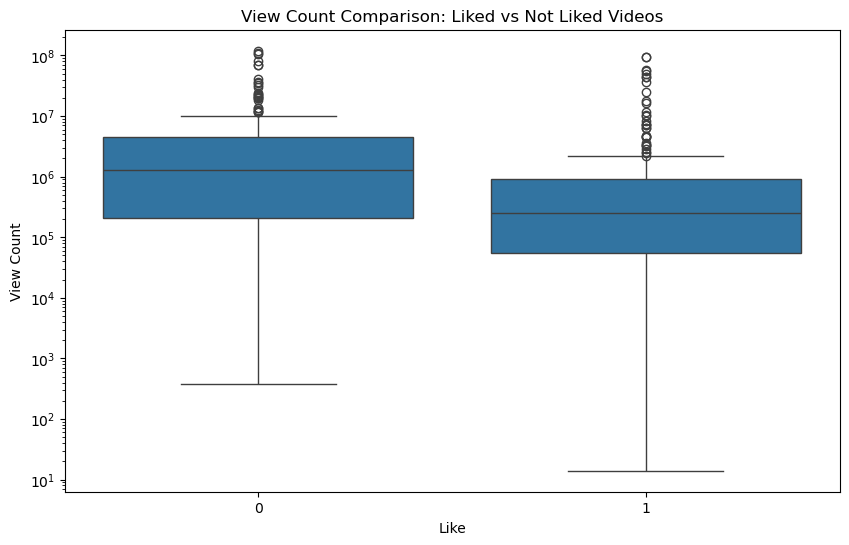

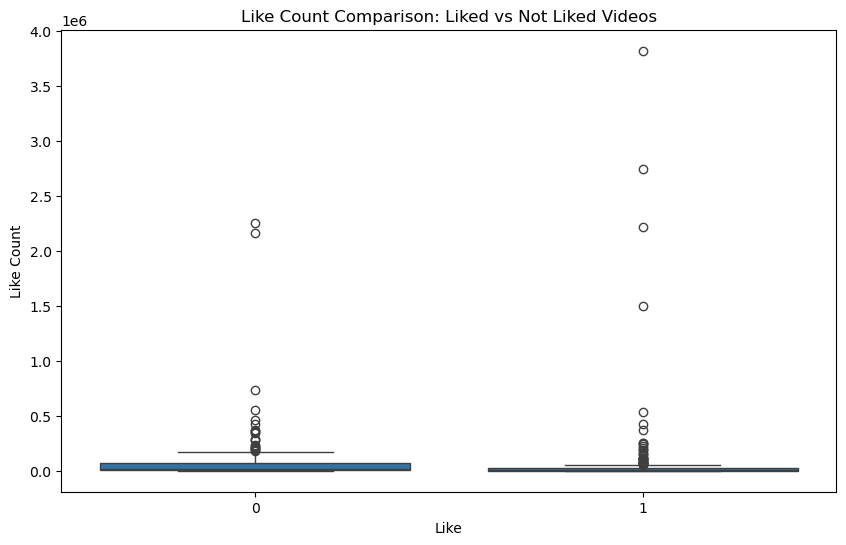

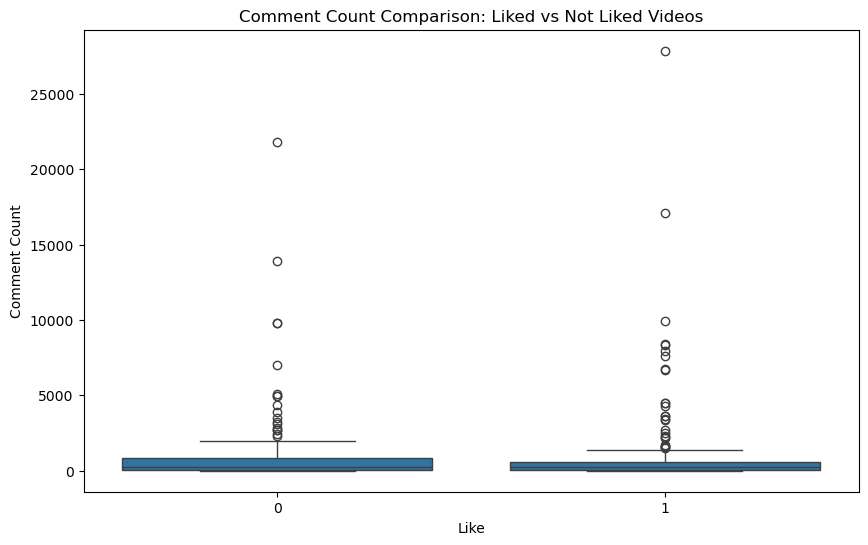

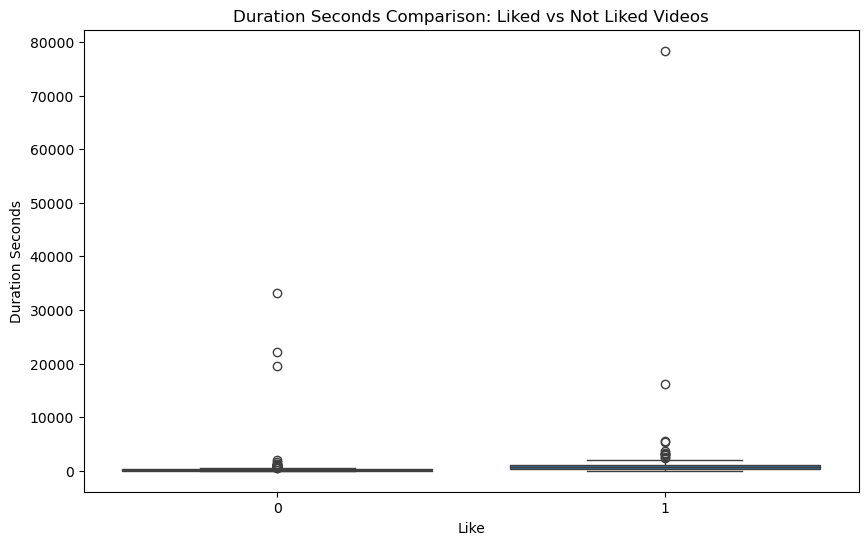

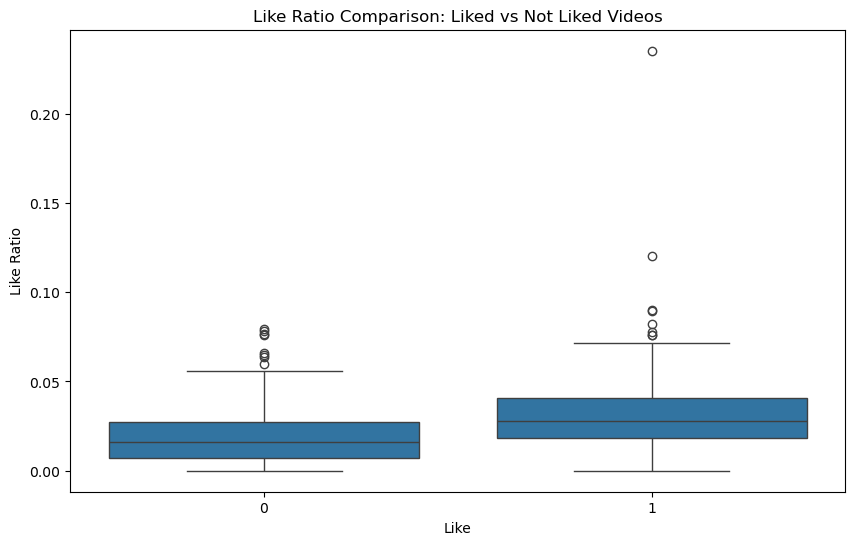

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summarize the dataset
print("\nDataset Summary:")
print(df.describe())

# Function to visualize comparison of liked and unliked videos for different numerical variables
def visualize_numerical_variable(df, variable, log_scale=True):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="like", y=variable, data=df)
    plt.title(f"{variable.replace('_', ' ').title()} Comparison: Liked vs Not Liked Videos")
    plt.xlabel("Like")
    plt.ylabel(variable.replace('_', ' ').title())
    
    if log_scale:
        plt.yscale("log")  # Use log scale if specified
    
    plt.show()

# Visualize different numerical variables
numerical_variables = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio']

# Iterate over the list of numerical variables and visualize them
for variable in numerical_variables:
    visualize_numerical_variable(df, variable, log_scale=True if variable == 'view_count' else False)


Mean of view_count for liked videos: 3553136.88
Mean of view_count for not liked videos: 6582058.76

Mean of like_count for liked videos: 81924.01
Mean of like_count for not liked videos: 81208.74

Mean of comment_count for liked videos: 958.87
Mean of comment_count for not liked videos: 925.34

Mean of duration_seconds for liked videos: 1264.39
Mean of duration_seconds for not liked videos: 591.16

Mean of like_ratio for liked videos: 0.03
Mean of like_ratio for not liked videos: 0.02



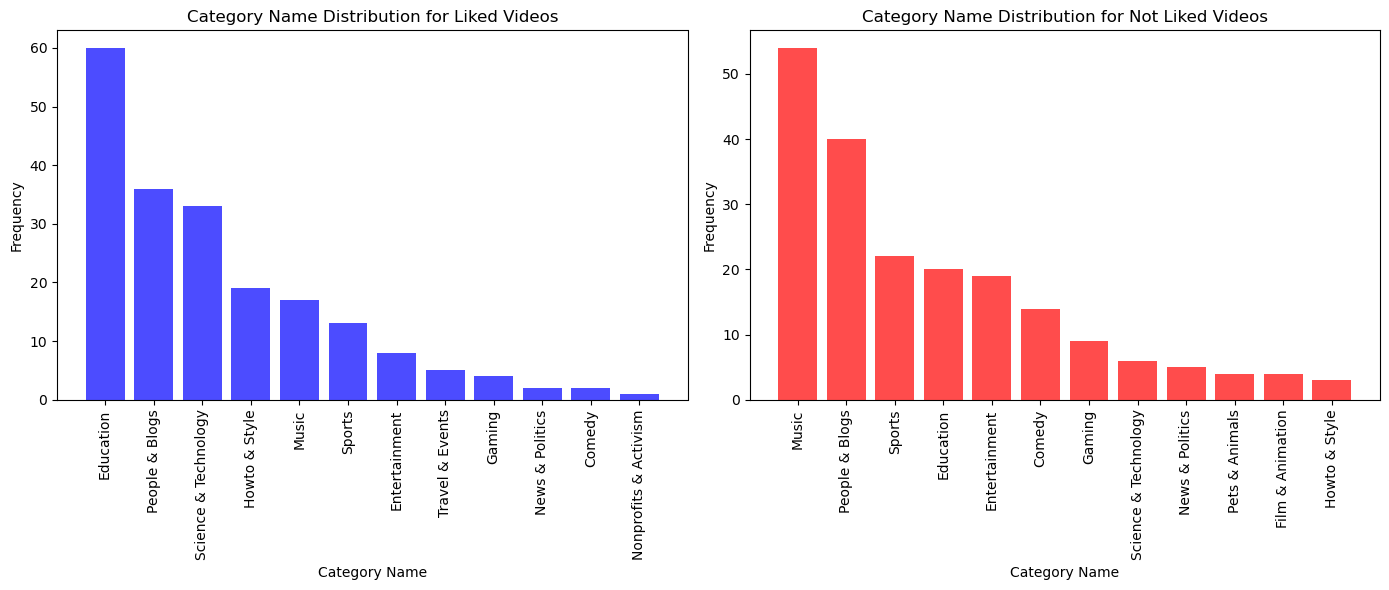

In [159]:
import matplotlib.pyplot as plt
import pandas as pd

# Compare means of numerical features for 'like' and 'not like' groups
liked_group = df[df['like'] == 1]
unliked_group = df[df['like'] == 0]

numerical_features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio']

for feature in numerical_features:
    liked_mean = liked_group[feature].mean()
    unliked_mean = unliked_group[feature].mean()
    print(f"Mean of {feature} for liked videos: {liked_mean:.2f}")
    print(f"Mean of {feature} for not liked videos: {unliked_mean:.2f}\n")

# Convert category_id to strings
# Define category mapping
category_mapping = {
    '1': 'Film & Animation',
    '2': 'Autos & Vehicles',
    '10': 'Music',
    '15': 'Pets & Animals',
    '17': 'Sports',
    '18': 'Short Movies',
    '19': 'Travel & Events',
    '20': 'Gaming',
    '21': 'Videoblogging',
    '22': 'People & Blogs',
    '23': 'Comedy',
    '24': 'Entertainment',
    '25': 'News & Politics',
    '26': 'Howto & Style',
    '27': 'Education',
    '28': 'Science & Technology',
    '29': 'Nonprofits & Activism'
}

# Convert category_id to strings and map to category names
df['category_id'] = df['category_id'].astype(str).map(category_mapping).fillna(df['category_id'])

# Rank categories by frequency
liked_category_counts = liked_group['category_id'].value_counts()
unliked_category_counts = unliked_group['category_id'].value_counts()

liked_categories_sorted = liked_category_counts.index
unliked_categories_sorted = unliked_category_counts.index

# Visualize category_id in histograms for like and unlike groups
plt.figure(figsize=(14, 6))

# Histogram for liked group
plt.subplot(1, 2, 1)
plt.bar(liked_categories_sorted, liked_category_counts[liked_categories_sorted], color='blue', alpha=0.7)
plt.title("Category Distribution for Liked Videos")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

# Histogram for unliked group
plt.subplot(1, 2, 2)
plt.bar(unliked_categories_sorted, unliked_category_counts[unliked_categories_sorted], color='red', alpha=0.7)
plt.title("Category Distribution for Not Liked Videos")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

# Define the features and target variable
features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio']
target = 'like'

# Split the data into features (X) and target (y)
X = df[features]
y = df[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.59
Confusion Matrix:
[[22 14]
 [19 25]]
ROC-AUC Score: 0.59

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57        36
           1       0.64      0.57      0.60        44

    accuracy                           0.59        80
   macro avg       0.59      0.59      0.59        80
weighted avg       0.59      0.59      0.59        80



In [115]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import pandas as pd

# Define the features and target variable
features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio', 'category_id']
target = 'like'

# Split the data into features (X) and target (y)
X = df[features]
y = df[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling for numerical features and one-hot encoding for categorical features
numerical_features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio']
categorical_features = ['category_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create a pipeline with preprocessing and logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Train the logistic regression model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.79
Confusion Matrix:
[[26 10]
 [ 7 37]]
ROC-AUC Score: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.75        36
           1       0.79      0.84      0.81        44

    accuracy                           0.79        80
   macro avg       0.79      0.78      0.78        80
weighted avg       0.79      0.79      0.79        80



In [170]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the target variable
target = 'like'

# Combine title and description into a single text feature
df['combined_text'] = df['title'].astype(str) + ' '  + df['topic_categories_extracted'].astype(str)

# Convert combined text to feature matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['combined_text'])
y = df[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Naive Bayes model
nb_model = MultinomialNB()

# Train Naive Bayes model
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# NLP with title and description
# Tokenize titles and descriptions and count word frequency
df['combined_text'] = df['combined_text'].astype(str)
stop_words = set(stopwords.words('english'))

def tokenize_and_filter(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

# Apply tokenization
df['tokenized_combined'] = df['combined_text'].apply(tokenize_and_filter)

# Count word frequencies for 'like' and 'not like' groups
liked_words = df[df['like'] == 1]['tokenized_combined'].sum()
unliked_words = df[df['like'] == 0]['tokenized_combined'].sum()

liked_word_freq = Counter(liked_words)
unliked_word_freq = Counter(unliked_words)

# Get the most common words in each group
most_common_liked = liked_word_freq.most_common(10)
most_common_unliked = unliked_word_freq.most_common(10)

print("\nMost Common Words in Liked Videos:")
print(most_common_liked)
print("\nMost Common Words in Not Liked Videos:")
print(most_common_unliked)

Accuracy: 0.85
Confusion Matrix:
[[29  7]
 [ 5 39]]
ROC-AUC Score: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        36
           1       0.85      0.89      0.87        44

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80


Most Common Words in Liked Videos:
[('knowledge', 72), ('technology', 45), ('sociology', 30), ('music', 21), ('python', 17), ('food', 15), ('learn', 10), ('방법', 10), ('sport', 10), ('health', 10)]

Most Common Words in Not Liked Videos:
[('music', 62), ('entertainment', 26), ('sport', 22), ('knowledge', 15), ('film', 14), ('sociology', 9), ('shorts', 8), ('humour', 6), ('society', 6), ('leetcode', 6)]


In [171]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define the target variable
target = 'like'

# Convert title and topic categories extracted to separate features
vectorizer_title = CountVectorizer(stop_words='english')
vectorizer_topic = CountVectorizer(stop_words='english')

# Convert title to feature matrix
title_features = vectorizer_title.fit_transform(df['title'].astype(str))

# Convert topic categories extracted to feature matrix
topic_features = vectorizer_topic.fit_transform(df['topic_categories_extracted'].astype(str))

# Combine title and topic features
from scipy.sparse import hstack
X = hstack([title_features, topic_features])
y = df[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Naive Bayes model
nb_model = MultinomialNB()

# Train Naive Bayes model
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# NLP with title and topic categories
stop_words = set(stopwords.words('english'))

def tokenize_and_filter(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

# Apply tokenization to title and topic categories separately
df['tokenized_title'] = df['title'].astype(str).apply(tokenize_and_filter)
df['tokenized_topic'] = df['topic_categories_extracted'].astype(str).apply(tokenize_and_filter)

# Count word frequencies for 'like' and 'not like' groups
liked_words_title = df[df['like'] == 1]['tokenized_title'].sum()
unliked_words_title = df[df['like'] == 0]['tokenized_title'].sum()

# Count word frequencies for 'like' and 'not like' groups
liked_words_topic = df[df['like'] == 1]['tokenized_topic'].sum()
unliked_words_topic = df[df['like'] == 0]['tokenized_topic'].sum()

liked_word_freq_title = Counter(liked_words_title)
unliked_word_freq_title = Counter(unliked_words_title)

liked_word_freq_topic = Counter(liked_words_topic)
unliked_word_freq_topic = Counter(unliked_words_topic)

# Get the most common words in each group for titles
most_common_liked_title = liked_word_freq_title.most_common(10)
most_common_unliked_title = unliked_word_freq_title.most_common(10)

# Get the most common words in each group for topics
most_common_liked_topic = liked_word_freq_topic.most_common(10)
most_common_unliked_topic = unliked_word_freq_topic.most_common(10)

print("\nMost Common Words in Liked Videos (Title):")
print(most_common_liked_title)
print("\nMost Common Words in Not Liked Videos (Title):")
print(most_common_unliked_title)

print("\nMost Common Words in Liked Videos (Topic):")
print(most_common_liked_topic)
print("\nMost Common Words in Not Liked Videos (Topic):")
print(most_common_unliked_topic)

Accuracy: 0.85
Confusion Matrix:
[[29  7]
 [ 5 39]]
ROC-AUC Score: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        36
           1       0.85      0.89      0.87        44

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80


Most Common Words in Liked Videos (Title):
[('python', 17), ('learn', 10), ('방법', 10), ('2024', 8), ('learning', 7), ('5', 7), ('tutorial', 6), ('이유', 6), ('api', 5), ('오사카', 5)]

Most Common Words in Not Liked Videos (Title):
[('shorts', 8), ('leetcode', 6), ('진짜', 5), ('love', 5), ('이유', 4), ('vs', 4), ('let', 4), ('한', 4), ('본', 4), ('python', 4)]

Most Common Words in Liked Videos (Topic):
[('knowledge', 72), ('technology', 45), ('sociology', 30), ('music', 21), ('food', 15), ('sport', 10), ('health', 10), ('society', 9), ('business', 6), ('tourism', 6)]

Most Commo

[nltk_data] Downloading package punkt to /Users/hcoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hcoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the target variable
target = 'like'

# Convert titles to feature matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['title'].astype(str))
y = df[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Naive Bayes model
nb_model = MultinomialNB()

# Train Naive Bayes model
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.70
Confusion Matrix:
[[30  6]
 [18 26]]
ROC-AUC Score: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        36
           1       0.81      0.59      0.68        44

    accuracy                           0.70        80
   macro avg       0.72      0.71      0.70        80
weighted avg       0.73      0.70      0.70        80



In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define the features and target variable
features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio', 'category_id']
target = 'like'

# Split the data into features (X) and target (y)
X = df[features]
y = df[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling for numerical features and one-hot encoding for categorical features
numerical_features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio']
categorical_features = ['category_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create logistic regression pipeline
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Train logistic regression model
logistic_pipeline.fit(X_train, y_train)

# Create Naive Bayes model (using MultinomialNB for text features)
nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Create a voting classifier to combine Logistic Regression and Naive Bayes
voting_model = VotingClassifier(estimators=[
    ('logistic', logistic_pipeline),
    ('naive_bayes', nb_pipeline)
], voting='soft')

# Train the voting model
voting_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = voting_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# NLP with title
# Tokenize titles and count word frequency
df['title'] = df['title'].astype(str)
stop_words = set(stopwords.words('english'))

def tokenize_and_filter(title):
    words = word_tokenize(title.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words



Accuracy: 0.80
Confusion Matrix:
[[29  7]
 [ 9 35]]
ROC-AUC Score: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78        36
           1       0.83      0.80      0.81        44

    accuracy                           0.80        80
   macro avg       0.80      0.80      0.80        80
weighted avg       0.80      0.80      0.80        80


Most Common Words in Liked Videos:
[('python', 17), ('learn', 10), ('방법', 10), ('2024', 8), ('learning', 7), ('5', 7), ('tutorial', 6), ('이유', 6), ('api', 5), ('오사카', 5)]

Most Common Words in Not Liked Videos:
[('shorts', 8), ('leetcode', 6), ('진짜', 5), ('love', 5), ('이유', 4), ('vs', 4), ('let', 4), ('한', 4), ('본', 4), ('python', 4)]


[nltk_data] Downloading package punkt to /Users/hcoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hcoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define the target variable
target = 'like'

# Combine title and description into a single text feature
df['combined_text'] = df['title'].astype(str) + ' ' + df['description'].astype(str)

# Convert combined text to feature matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
text_features = vectorizer.fit_transform(df['combined_text']).toarray()

# Define numerical and categorical features
numerical_features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio']
categorical_features = pd.get_dummies(df['category_id']).values
numerical_data = df[numerical_features].fillna(0).values

# Combine numerical, categorical, and text features
X = np.hstack((numerical_data, categorical_features, text_features))
y = df[target].values

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling for numerical features
scaler = StandardScaler()
X_train[:, :len(numerical_features)] = scaler.fit_transform(X_train[:, :len(numerical_features)])
X_test[:, :len(numerical_features)] = scaler.transform(X_test[:, :len(numerical_features)])

# Convert target variable to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Create Neural Network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# NLP with title and description
# Tokenize titles and descriptions and count word frequency
df['combined_text'] = df['combined_text'].astype(str)
stop_words = set(stopwords.words('english'))

def tokenize_and_filter(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

# Apply tokenization
df['tokenized_combined'] = df['combined_text'].apply(tokenize_and_filter)

# Count word frequencies for 'like' and 'not like' groups
liked_words = df[df['like'] == 1]['tokenized_combined'].sum()
unliked_words = df[df['like'] == 0]['tokenized_combined'].sum()

liked_word_freq = Counter(liked_words)
unliked_word_freq = Counter(unliked_words)

# Get the most common words in each group
most_common_liked = liked_word_freq.most_common(10)
most_common_unliked = unliked_word_freq.most_common(10)

print("\nMost Common Words in Liked Videos:")
print(most_common_liked)
print("\nMost Common Words in Not Liked Videos:")
print(most_common_unliked)

Epoch 1/10


[nltk_data] Downloading package punkt to /Users/hcoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hcoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5294 - loss: 0.7391 - val_accuracy: 0.7000 - val_loss: 0.6136
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6781 - loss: 0.5964 - val_accuracy: 0.7375 - val_loss: 0.5896
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8310 - loss: 0.4857 - val_accuracy: 0.8000 - val_loss: 0.5794
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9046 - loss: 0.3947 - val_accuracy: 0.8375 - val_loss: 0.5826
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9263 - loss: 0.3348 - val_accuracy: 0.8250 - val_loss: 0.5992
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9447 - loss: 0.2474 - val_accuracy: 0.8375 - val_loss: 0.6357
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9723 - loss: 0.2010 - val_accuracy: 0.8375 - val_loss: 0.6737
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9570 - loss: 0.1464 - val_accuracy: 0.8250 - val_loss: 0.

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define the target variable
target = 'like'

# Combine title and description into a single text feature
df['combined_text'] = df['title'].astype(str) + ' ' + df['description'].astype(str)

# Convert combined text to feature matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
text_features = vectorizer.fit_transform(df['combined_text']).toarray()

# Define numerical and categorical features
numerical_features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio']
categorical_features = pd.get_dummies(df['category_id']).values
numerical_data = df[numerical_features].fillna(0).values

# Combine numerical, categorical, and text features
X = np.hstack((numerical_data, categorical_features, text_features))
y = df[target].values

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling for numerical features
scaler = StandardScaler()
X_train[:, :len(numerical_features)] = scaler.fit_transform(X_train[:, :len(numerical_features)])
X_test[:, :len(numerical_features)] = scaler.transform(X_test[:, :len(numerical_features)])

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# NLP with title and description
# Tokenize titles and descriptions and count word frequency
df['combined_text'] = df['combined_text'].astype(str)
stop_words = set(stopwords.words('english'))

def tokenize_and_filter(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

# Apply tokenization
df['tokenized_combined'] = df['combined_text'].apply(tokenize_and_filter)

# Count word frequencies for 'like' and 'not like' groups
liked_words = df[df['like'] == 1]['tokenized_combined'].sum()
unliked_words = df[df['like'] == 0]['tokenized_combined'].sum()

liked_word_freq = Counter(liked_words)
unliked_word_freq = Counter(unliked_words)

# Get the most common words in each group
most_common_liked = liked_word_freq.most_common(10)
most_common_unliked = unliked_word_freq.most_common(10)

print("\nMost Common Words in Liked Videos:")
print(most_common_liked)
print("\nMost Common Words in Not Liked Videos:")
print(most_common_unliked)

[nltk_data] Downloading package punkt to /Users/hcoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hcoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.80
Confusion Matrix:
[[30  6]
 [10 34]]
ROC-AUC Score: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        36
           1       0.85      0.77      0.81        44

    accuracy                           0.80        80
   macro avg       0.80      0.80      0.80        80
weighted avg       0.81      0.80      0.80        80


Most Common Words in Liked Videos:
[('https', 840), ('data', 99), ('python', 94), ('수', 88), ('video', 86), ('learn', 71), ('free', 64), ('code', 63), ('course', 59), ('get', 57)]

Most Common Words in Not Liked Videos:
[('https', 231), ('youtube', 99), ('composer', 67), ('provided', 50), ('music', 44), ('released', 43), ('entertainment', 39), ('arranger', 36), ('shorts', 33), ('kakao', 31)]


In [134]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [141]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


# Define the target variable
target = 'like'

# Combine title and description into a single text feature
df['combined_text'] = df['title'].astype(str) + ' ' + df['description'].astype(str)

# Convert combined text to feature matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
text_features = vectorizer.fit_transform(df['combined_text']).toarray()

# Define numerical and categorical features
numerical_features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'like_ratio']
categorical_features = pd.get_dummies(df['category_id']).values
numerical_data = df[numerical_features].fillna(0).values

# Combine numerical, categorical, and text features
X = np.hstack((numerical_data, categorical_features, text_features))
y = df[target].values

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling for numerical features
scaler = StandardScaler()
X_train[:, :len(numerical_features)] = scaler.fit_transform(X_train[:, :len(numerical_features)])
X_test[:, :len(numerical_features)] = scaler.transform(X_test[:, :len(numerical_features)])

# Convert target variable to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Create Neural Network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5108 - loss: 0.6736 - val_accuracy: 0.6000 - val_loss: 0.6191
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7217 - loss: 0.5780 - val_accuracy: 0.7875 - val_loss: 0.6130
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7653 - loss: 0.5486 - val_accuracy: 0.8250 - val_loss: 0.6003
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9065 - loss: 0.4183 - val_accuracy: 0.8125 - val_loss: 0.6026
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8707 - loss: 0.3615 - val_accuracy: 0.8250 - val_loss: 0.6101
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9431 - loss: 0.2675 - val_accuracy: 0.8250 - val_loss: 0.6466
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9621 - loss: 0.2223 - val_accuracy: 0.8250 - val_loss: 0.7034
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9637 - loss: 0.1762 - val_accuracy: 0.8375 - val_loss: 0.7654
Ep

In [149]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

class ImprovedNeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, batch_size=32, epochs=100, l2_reg=0.01):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.l2_reg = l2_reg
        
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases
        all_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(all_sizes)):
            self.weights.append(np.random.randn(all_sizes[i-1], all_sizes[i]) * np.sqrt(2. / all_sizes[i-1]))
            self.biases.append(np.zeros((1, all_sizes[i])))
    
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        return Z > 0
    
    def leaky_relu(self, Z, alpha=0.01):
        return np.maximum(alpha * Z, Z)
    
    def leaky_relu_derivative(self, Z, alpha=0.01):
        dZ = np.ones_like(Z)
        dZ[Z < 0] = alpha
        return dZ
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / expZ.sum(axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        activations = [X]
        Zs = []
        
        for i in range(len(self.weights) - 1):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            A = self.leaky_relu(Z)
            Zs.append(Z)
            activations.append(A)
        
        Z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        A = self.softmax(Z)
        Zs.append(Z)
        activations.append(A)
        
        return activations, Zs
    
    def backward_propagation(self, X, y, activations, Zs):
        m = X.shape[0]
        gradients = []
        
        dZ = activations[-1] - y
        dW = np.dot(activations[-2].T, dZ) / m + (self.l2_reg * self.weights[-1])
        db = np.sum(dZ, axis=0, keepdims=True) / m
        gradients.append((dW, db))
        
        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * self.leaky_relu_derivative(Zs[i])
            dW = np.dot(activations[i].T, dZ) / m + (self.l2_reg * self.weights[i])
            db = np.sum(dZ, axis=0, keepdims=True) / m
            gradients.append((dW, db))
        
        return gradients[::-1]
    
    def update_parameters(self, gradients):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients[i][0]
            self.biases[i] -= self.learning_rate * gradients[i][1]
    
    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        n_samples = X_train.shape[0]
        n_batches = n_samples // self.batch_size
        
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        
        for epoch in range(self.epochs):
            # Shuffle the data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for batch in range(n_batches):
                start = batch * self.batch_size
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                # Convert y_batch to one-hot encoding
                y_batch_one_hot = np.eye(self.output_size)[y_batch]
                
                activations, Zs = self.forward_propagation(X_batch)
                gradients = self.backward_propagation(X_batch, y_batch_one_hot, activations, Zs)
                self.update_parameters(gradients)
            
            # Compute validation loss
            val_activations, _ = self.forward_propagation(X_val)
            val_predictions = val_activations[-1]
            val_loss = -np.mean(np.log(val_predictions[np.arange(len(y_val)), y_val]))
            
            print(f"Epoch {epoch + 1}/{self.epochs}, Validation Loss: {val_loss:.4f}")
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
    
    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=1)

# Usage
nn = ImprovedNeuralNetwork(input_size=X.shape[1], hidden_sizes=[128, 64], output_size=2)
nn.fit(X_train, y_train)

# Make predictions
y_pred = nn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Epoch 1/100, Validation Loss: 0.6939
Epoch 2/100, Validation Loss: 0.6904
Epoch 3/100, Validation Loss: 0.6874
Epoch 4/100, Validation Loss: 0.6846
Epoch 5/100, Validation Loss: 0.6822
Epoch 6/100, Validation Loss: 0.6800
Epoch 7/100, Validation Loss: 0.6781
Epoch 8/100, Validation Loss: 0.6764
Epoch 9/100, Validation Loss: 0.6748
Epoch 10/100, Validation Loss: 0.6733
Epoch 11/100, Validation Loss: 0.6719
Epoch 12/100, Validation Loss: 0.6706
Epoch 13/100, Validation Loss: 0.6694
Epoch 14/100, Validation Loss: 0.6683
Epoch 15/100, Validation Loss: 0.6672
Epoch 16/100, Validation Loss: 0.6663
Epoch 17/100, Validation Loss: 0.6653
Epoch 18/100, Validation Loss: 0.6645
Epoch 19/100, Validation Loss: 0.6637
Epoch 20/100, Validation Loss: 0.6629
Epoch 21/100, Validation Loss: 0.6622
Epoch 22/100, Validation Loss: 0.6615
Epoch 23/100, Validation Loss: 0.6608
Epoch 24/100, Validation Loss: 0.6602
Epoch 25/100, Validation Loss: 0.6595
Epoch 26/100, Validation Loss: 0.6590
Epoch 27/100, Validat

In [152]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

class StableNeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, batch_size=32, epochs=100, l2_reg=0.01):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.l2_reg = l2_reg
        
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases with Xavier/Glorot initialization
        all_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(all_sizes)):
            limit = np.sqrt(6 / (all_sizes[i-1] + all_sizes[i]))
            self.weights.append(np.random.uniform(-limit, limit, (all_sizes[i-1], all_sizes[i])))
            self.biases.append(np.zeros((1, all_sizes[i])))
    
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        return Z > 0
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        activations = [X]
        Zs = []
        
        for i in range(len(self.weights) - 1):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            A = self.relu(Z)
            Zs.append(Z)
            activations.append(A)
        
        Z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        A = self.softmax(Z)
        Zs.append(Z)
        activations.append(A)
        
        return activations, Zs
    
    def backward_propagation(self, X, y, activations, Zs):
        m = X.shape[0]
        gradients = []
        
        dZ = activations[-1] - y
        dW = np.dot(activations[-2].T, dZ) / m + (self.l2_reg * self.weights[-1])
        db = np.sum(dZ, axis=0, keepdims=True) / m
        gradients.append((dW, db))
        
        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * self.relu_derivative(Zs[i])
            dW = np.dot(activations[i].T, dZ) / m + (self.l2_reg * self.weights[i])
            db = np.sum(dZ, axis=0, keepdims=True) / m
            gradients.append((dW, db))
        
        return gradients[::-1]
    
    def update_parameters(self, gradients):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients[i][0]
            self.biases[i] -= self.learning_rate * gradients[i][1]
    
    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Normalize the input data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        
        n_samples = X_train.shape[0]
        n_batches = n_samples // self.batch_size
        
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        
        for epoch in range(self.epochs):
            # Shuffle the data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for batch in range(n_batches):
                start = batch * self.batch_size
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                # Convert y_batch to one-hot encoding
                y_batch_one_hot = np.eye(self.output_size)[y_batch]
                
                activations, Zs = self.forward_propagation(X_batch)
                gradients = self.backward_propagation(X_batch, y_batch_one_hot, activations, Zs)
                self.update_parameters(gradients)
            
            # Compute validation loss
            val_activations, _ = self.forward_propagation(X_val)
            val_predictions = val_activations[-1]
            
            # Add epsilon to avoid log(0)
            epsilon = 1e-15
            val_predictions = np.clip(val_predictions, epsilon, 1 - epsilon)
            
            val_loss = -np.mean(np.log(val_predictions[np.arange(len(y_val)), y_val]))
            
            print(f"Epoch {epoch + 1}/{self.epochs}, Validation Loss: {val_loss:.4f}")
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
    
    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=1)

# Usage
input_size = X.shape[1]  # Assuming X is your feature matrix
output_size = 2  # Assuming binary classification

nn = StableNeuralNetwork(
    input_size=input_size,
    hidden_sizes=[64, 32],
    output_size=output_size,
    learning_rate=0.001,
    batch_size=32,
    epochs=100,
    l2_reg=0.01
)

# Normalize the input data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

nn.fit(X_train, y_train)

# Make predictions
y_pred = nn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/100, Validation Loss: 0.7595
Epoch 2/100, Validation Loss: 0.7517
Epoch 3/100, Validation Loss: 0.7462
Epoch 4/100, Validation Loss: 0.7418
Epoch 5/100, Validation Loss: 0.7381
Epoch 6/100, Validation Loss: 0.7350
Epoch 7/100, Validation Loss: 0.7324
Epoch 8/100, Validation Loss: 0.7302
Epoch 9/100, Validation Loss: 0.7282
Epoch 10/100, Validation Loss: 0.7264
Epoch 11/100, Validation Loss: 0.7248
Epoch 12/100, Validation Loss: 0.7234
Epoch 13/100, Validation Loss: 0.7221
Epoch 14/100, Validation Loss: 0.7208
Epoch 15/100, Validation Loss: 0.7197
Epoch 16/100, Validation Loss: 0.7186
Epoch 17/100, Validation Loss: 0.7177
Epoch 18/100, Validation Loss: 0.7169
Epoch 19/100, Validation Loss: 0.7161
Epoch 20/100, Validation Loss: 0.7154
Epoch 21/100, Validation Loss: 0.7148
Epoch 22/100, Validation Loss: 0.7142
Epoch 23/100, Validation Loss: 0.7136
Epoch 24/100, Validation Loss: 0.7131
Epoch 25/100, Validation Loss: 0.7127
Epoch 26/100, Validation Loss: 0.7122
Epoch 27/100, Validat

In [153]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from itertools import product
import time


def grid_search(X, y):
    # Define the hyperparameters to tune
    param_grid = {
        'hidden_sizes': [[32], [64], [128], [64, 32], [128, 64]],
        'learning_rate': [0.001, 0.01, 0.1],
        'batch_size': [32, 64, 128],
        'l2_reg': [0.001, 0.01, 0.1],
        'epochs': [10, 50, 100]
    }

    # Generate all combinations of hyperparameters
    param_combinations = list(product(*param_grid.values()))

    best_accuracy = 0
    best_params = None

    # Normalize the data
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Split the data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    total_combinations = len(param_combinations)
    start_time = time.time()

    for i, params in enumerate(param_combinations, 1):
        hidden_sizes, learning_rate, batch_size, l2_reg, epochs = params
        
        print(f"\nTesting combination {i}/{total_combinations}")
        print(f"Parameters: hidden_sizes={hidden_sizes}, learning_rate={learning_rate}, "
              f"batch_size={batch_size}, l2_reg={l2_reg}, epochs={epochs}")

        # Create and train the model
        model = StableNeuralNetwork(
            input_size=X.shape[1],
            hidden_sizes=hidden_sizes,
            output_size=len(np.unique(y)),
            learning_rate=learning_rate,
            batch_size=batch_size,
            epochs=epochs,
            l2_reg=l2_reg
        )

        model.fit(X_train, y_train)

        # Make predictions and calculate accuracy on validation set
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)

        print(f"Validation Accuracy: {accuracy:.4f}")

        # Update best parameters if current model performs better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

        # Estimate time remaining
        elapsed_time = time.time() - start_time
        avg_time_per_combination = elapsed_time / i
        remaining_combinations = total_combinations - i
        estimated_time_remaining = avg_time_per_combination * remaining_combinations

        print(f"Estimated time remaining: {estimated_time_remaining/60:.2f} minutes")

    # Train the final model with the best parameters
    final_model = StableNeuralNetwork(
        input_size=X.shape[1],
        hidden_sizes=best_params[0],
        output_size=len(np.unique(y)),
        learning_rate=best_params[1],
        batch_size=best_params[2],
        epochs=best_params[4],
        l2_reg=best_params[3]
    )

    final_model.fit(X_train_val, y_train_val)

    # Evaluate the final model on the test set
    y_test_pred = final_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    return best_params, best_accuracy, test_accuracy, final_model

# Assuming X and y are your features and target variables
best_params, best_val_accuracy, test_accuracy, final_model = grid_search(X, y)

print("\nBest Hyperparameters:")
print(f"Hidden Sizes: {best_params[0]}")
print(f"Learning Rate: {best_params[1]}")
print(f"Batch Size: {best_params[2]}")
print(f"L2 Regularization: {best_params[3]}")
print(f"Epochs: {best_params[4]}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# If you want to save the best model for later use
import joblib
joblib.dump(final_model, 'best_neural_network_model.joblib')


Testing combination 1/405
Parameters: hidden_sizes=[32], learning_rate=0.001, batch_size=32, l2_reg=0.001, epochs=10
Epoch 1/10, Validation Loss: 0.8017
Epoch 2/10, Validation Loss: 0.7920
Epoch 3/10, Validation Loss: 0.7847
Epoch 4/10, Validation Loss: 0.7790
Epoch 5/10, Validation Loss: 0.7744
Epoch 6/10, Validation Loss: 0.7703
Epoch 7/10, Validation Loss: 0.7671
Epoch 8/10, Validation Loss: 0.7643
Epoch 9/10, Validation Loss: 0.7605
Epoch 10/10, Validation Loss: 0.7581
Validation Accuracy: 0.5625
Estimated time remaining: 2.31 minutes

Testing combination 2/405
Parameters: hidden_sizes=[32], learning_rate=0.001, batch_size=32, l2_reg=0.001, epochs=50
Epoch 1/50, Validation Loss: 0.8147
Epoch 2/50, Validation Loss: 0.8058
Epoch 3/50, Validation Loss: 0.7984
Epoch 4/50, Validation Loss: 0.7924
Epoch 5/50, Validation Loss: 0.7877
Epoch 6/50, Validation Loss: 0.7831
Epoch 7/50, Validation Loss: 0.7787
Epoch 8/50, Validation Loss: 0.7750
Epoch 9/50, Validation Loss: 0.7720
Epoch 10/50,

['best_neural_network_model.joblib']